利用Torchvision现成的功能进行测试
From Post: https://docs.pytorch.org/tutorials/intermediate/torchvision_tutorial.html

数据集: PennFudan
```bash
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip 
```

In [9]:
# 自动重新加载外部module，使得修改代码之后无需重新import
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from hdd.device.utils import get_device

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from pathlib import Path

# 设置训练数据的路径
DATA_ROOT = Path("~/workspace/hands-dirty-on-dl/dataset").expanduser()
# 设置预训练模型参数路径
TORCH_HUB_PATH = Path("~/workspace/hands-dirty-on-dl/pretrained_models").expanduser()
torch.hub.set_dir(TORCH_HUB_PATH)
# 挑选最合适的训练设备
DEVICE = get_device(["cuda", "cpu"])
print("Use device: ", DEVICE)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Use device:  cuda


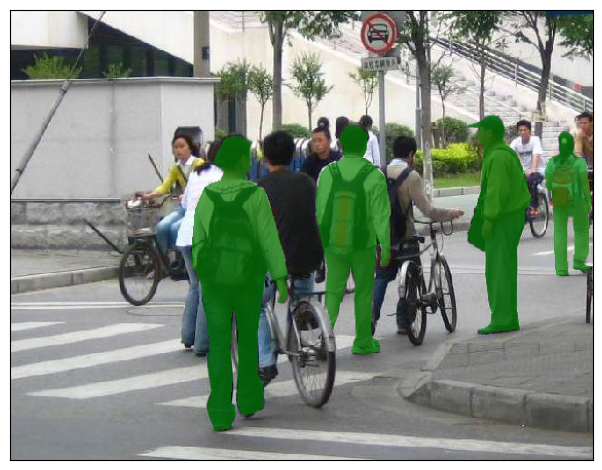

In [10]:
import matplotlib.pyplot as plt
from torchvision.io import read_image
from hdd.visualization.vis_utils import det_seg_plot

image = read_image(DATA_ROOT / "PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image(DATA_ROOT / "PennFudanPed/PedMasks/FudanPed00046_mask.png")

det_seg_plot([(image, {"masks": mask})])

In [11]:
import os
from rich import box
import torch
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    """It preloads images into memory, so it is not suitable for large datasets."""

    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms

        img_paths = list(sorted((self.root / "PNGImages").glob("*.png")))
        mask_paths = list(sorted((self.root / "PedMasks").glob("*.png")))

        assert len(img_paths) == len(
            mask_paths
        ), "Number of images and masks must be the same."

        # Preload images and masks into memory
        self.imgs = []
        self.masks = []
        for img_path, mask_path in zip(img_paths, mask_paths):
            self.imgs.append(read_image(img_path))
            self.masks.append(read_image(mask_path))

    def __getitem__(self, idx):
        img = self.imgs[idx].clone()
        mask = self.masks[idx].clone()

        obj_ids = torch.unique(mask)
        obj_ids = obj_ids[obj_ids != 0]  # Exclude background
        num_objs = len(obj_ids)

        # Each object has it own mask
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
        boxes = masks_to_boxes(masks)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {
            "boxes": tv_tensors.BoundingBoxes(
                boxes, format="XYXY", canvas_size=F.get_size(img)
            ),
            "masks": tv_tensors.Mask(mask),
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd,
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self) -> int:
        return len(self.imgs)


dataset = PennFudanDataset(DATA_ROOT / "PennFudanPed")

<Figure size 1200x1200 with 0 Axes>

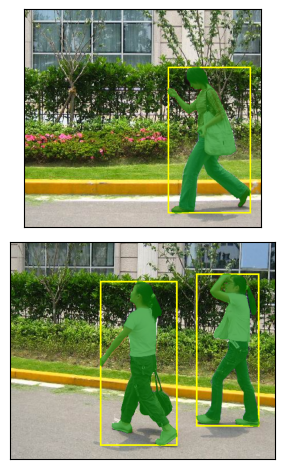

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))

images_to_plot = []
for i in range(10, 12):
    img, target = dataset[i]
    images_to_plot.append([(img, target)])
det_seg_plot(images_to_plot)


## Method 1 - Finetuning from a pretrained model
Let’s suppose that you want to start from a model pre-trained on COCO and want to finetune it for your particular classes. Here is a possible way of doing it:

In [13]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

## 2 - Modifying the model to add a different backbone

In [14]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=["0"], output_size=7, sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler,
)